# Importing packages

In [1]:
# Importing, cleaning and visualization
import pandas as pd
import seaborn as sns
import numpy as np
import plotly as py
import plotly.express as px
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# Model Validation
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
# Imputation
from sklearn.impute import KNNImputer
# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score,recall_score, precision_score
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
# Modelling
from sklearn.ensemble import RandomForestClassifier
# Balancing
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
# Scaling data
from sklearn.preprocessing import StandardScaler
from collections import Counter
# Model tuning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# Feature selection
from boruta import BorutaPy
# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

# Functions

In [2]:
# Function to remove missing values above a given threshold
def missing_remove(dataframe, threshold):
    """
    Functon to remove columns with missing data that is above the set percentage threshold limit
    
    Required arguments - 
    dataframe - Dataframe for processing(type-Pandas Dataframe)
    threshold - threshold above which columns will be removed(type-float)
    
    Optional arguments - None
    
    Expected output - Message with threshold value and number of columns removed
    Pandas Dataframe that does not contain columns that have more missing values than the threshold value
    
    """
    columns = dataframe.columns[(dataframe.isna().sum()/dataframe.shape[1])>threshold].tolist()
    print(f"# Features deleted with more than {threshold} % missing values", len(columns))
    return dataframe.drop(columns, axis=1,inplace=True)

In [3]:
def evaluate(model, X_train,X_test,y_train,y_test):
    """
    Function to fit any model on the train data and evaluate the model on the test data on the basis of confusion matric, 
    AUC, F1 Score, Sensitivity, Recall and Precision
    
    Required arguments - 
    model - Name of the model including model parameters
    X_train - training data
    X_test - test data
    y_train - training data
    y_test - validatation data
    
    Optional arguments - None
    
    Expected output - Output message - model name and parameters,Testing Accuracy, F1 score, Sensitivity, Recall, Precision
                      Plot of the Confusion matrix and AUC
    
    """
    figure(figsize=(8, 5), dpi=80)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm=confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d",cmap="YlOrRd",yticklabels = ['Act. Pass', 'Act. Fail'], xticklabels = ['Pred. Pass' , 'Pred. Fail'])
    ax = plt.gca()
    plot = plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8)
    print("Model Name:", model)
    print("Test Accuracy Score:", accuracy_score(y_test, y_pred))
    f1score = f1_score(y_test, y_pred, average='micro')
    sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
    recall = recall_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    print("F1 Score:", f1score) 
    print("Sensitivity:" , sensitivity)
    print("Recall:" , recall)
    print("Precision:" , precision)

In [4]:
def scaling(dataframe):
    """
    Function to scale the data 
    
    Required arguments - 
    dataframe - Dataframe for processing(type-Pandas Dataframe)
        
    Optional arguments - None
    
    Expected output - Pandas Dataframe with scaled data
    
    """
    scaler = StandardScaler()
    scaler.fit(dataframe)
    return pd.DataFrame(scaler.transform(dataframe), columns=dataframe.columns)
  

In [5]:
def replace_outlier(val, mean, std):
    """
    Function to replace a value that is greater that mean+3*standard deviation with mean+3*standard deviation
    
    Required arguments - 
    val - any value - float
    mean - mean of values -float
    std - standard deviation of values - float
        
    Optional arguments - None
    
    Expected output - If value is lower than mean+3*standard deviation then returns value
                      If value is higher than mean+3*standard deviation then returns mean+3*standard deviation    
    """
    if val > mean + 3*std:
        return mean + 3*std 
    elif val < mean - 3*std:
        return mean - 3*std
    return val

In [6]:
def BorutaFeatureSelection (X, y) :
    """
    A Function to fit any model on the train data and evaluate the model on the test data on the basis of confusion matric, 
    AUC, F1 Score, Sensitivity, Recall and Precision
    
    Required arguments - 
    model - Name of the model including model parameters
    X_train - training data
    X_test - test data
    y_train - training data target variable
    y_test - validatation data
    
    Optional arguments - None
    
    Expected output - Output message - model name and parameters,Testing Accuracy, F1 score, Sensitivity, Recall, Precision
                      Plot of the Confusion matrix and AUC
    """
    feature_names = np.array(X.columns)

    model = model = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=6,class_weight='balanced_subsample')
    model.fit(X, y)
    
    feature_selector = BorutaPy(model, random_state=2, verbose=2,max_iter=455,n_estimators=200)

    feature_selector.fit(X.to_numpy(),y)

    feature_selector.support_

    feature_selector.ranking_

    feature_ranks = list(zip(feature_names, 
                             feature_selector.ranking_, 
                             feature_selector.support_))

    for feat in feature_ranks:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 1)
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    print(final_features)
    
    return pd.DataFrame(X.filter(final_features)) , final_features

In [7]:
def Sampling(X_train, y_train, sampler):
    """
    Function to use any balacing technique on a dataframe
    
    Required arguments - 
    X_train - training data(pandas dataframe)
    y_train - training data target variable(pandas dataframe)
    sampler - Name of balacing technique(string)
    
    Optional arguments - None
    
    Expected output - Pandas Dataframe with balanced data
    
    # Himansha to add counter description
    """
    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    

    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
        
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)
        
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    counter = Counter(y_resampled)
    print(counter)
    return X_resampled, y_resampled

# Importing and basic cleaning

In [8]:
# Importing data from internet in runtime
data_url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"

In [9]:
# Assigning data to a pandas dataframe
secom_data = pd.read_csv(data_url,sep=' ',header=None)

In [10]:
# Renaming the columns 
secom_data.columns = ["Feature_"+str(column+1) for column in range(len(secom_data.columns))]
secom_data.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_581,Feature_582,Feature_583,Feature_584,Feature_585,Feature_586,Feature_587,Feature_588,Feature_589,Feature_590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [11]:
# Importing target data from internet in runtime
label_url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

In [12]:
# Assigning target data to a pandas dataframe
secom_labels = pd.read_csv(label_url, sep = " ",header=None)

In [13]:
# Renaming the columns 
secom_labels.columns = ["Classification","Timestamp"]

In [14]:
# Changing datatype for consitency
secom_labels['Timestamp'] = pd.to_datetime(secom_labels['Timestamp'],errors='raise')

In [15]:
# Merging the data
data= pd.concat([secom_labels,secom_data],axis=1)

In [16]:
# Dropping the timestamp column as it provides no insights
data.drop(columns="Timestamp", errors='raise',inplace=True)

In [17]:
# Using the classification column as the target variable
target = data[['Classification']]
data.drop(['Classification'], axis=1,inplace=True)

# Spliting the data into training set and test set

#### We split the data into a ratio of 80:20. Since the dataset is not large enough, we use 80% of the data for training. We will train the model on the training data and evaluate the model on the test data

#### We use the startify parameter as the data is imbalanced on the basis of pass and fail and this will ensure the same is retained when we split the data. The Random state argument will help us create a reproducible data. 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.20, random_state=42, stratify=target)

# Removing columns with more that 50% missing values

In [19]:
X_train_missing = X_train
missing_remove(X_train_missing, 0.5)

# Features deleted with more than 0.5 % missing values 32


In [51]:
X_test_missing = X_test[np.array(X_train_missing.columns)]

# Replacing outliers with 3s boundary

In [20]:
# replace with 3s in X_train
for col in X_train_missing.columns:
    mean = X_train_missing[col].mean()
    std_dev = X_train_missing[col].std(axis=0)
    X_train_missing[col] = X_train_missing[col].map(lambda x: replace_outlier(x, mean, std_dev))

# KNN Imputation

In [22]:
knn = KNNImputer()
knn.fit(X_train_missing)
X_train_knn=pd.DataFrame(knn.transform(X_train_missing), columns=X_train_missing.columns)
X_train_knn.isna().sum().sum()

0

In [23]:
import numpy as np
from keras.layers import Dense
from keras.models import Sequential

In [24]:
from keras.utils.np_utils import to_categorical 

In [57]:
target1 = to_categorical(y_train)

In [58]:
y_test1 = to_categorical(y_test)

In [35]:
print(f'''
Shape of y: {target.shape}
Shape of y_train: {y_train.shape}
Shape of y_test: {y_test.shape}''')


Shape of y: (1253, 2)
Shape of y_train: (1253, 1)
Shape of y_test: (314, 1)


In [52]:
n_cols = X_train_missing.shape()

TypeError: 'tuple' object is not callable

In [65]:
model = Sequential()
model.add(Dense(10,activation="relu",input_shape=(558,)))
model.add(Dense(10,activation="relu"))
model.add(Dense(10,activation="relu"))
model.add(Dense(2,activation="softmax"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
model.fit(X_train,target1,epochs=150, batch_size=10)

Epoch 1/150
126/126 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 2/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 6/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 7/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 8/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 9/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 10/150
126/126 [==============================] - 0s 1ms/step - loss: nan - 

126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 81/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 82/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 83/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 84/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 85/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 86/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 87/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 88/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 89/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accu

In [54]:
model.fit(X_train, target1, epochs=150, batch_size=10)

Epoch 1/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 2/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 6/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 7/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 8/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 9/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 10/150
126/126 [==============================] - 0s 2ms/step - loss: nan - 

126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 81/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 82/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 83/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 84/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 85/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 86/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 87/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 88/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 89/150
126/126 [==============================] - 0s 1ms/step - loss: nan - accu

In [55]:
# first of all, let's make class predictions with the model
# 
predictions = (model.predict(X_test_missing) > 0.5).astype(int)
# yep, it is that simple :)

# and with our predictions done, we can print the input data, predicted class and expected class for the first 10 examples in the dataset
for i in range(10):
	print('%s => %d (expected %d)' % (X_test_missing[i].tolist(), predictions[i], target1[i]))

10/10 [==============================] - 0s 2ms/step


KeyError: 0

In [60]:
# Now let's goone step further, and visualize how well our model is working using the good old Confusion Matrix 
print(f'Accuracy = {accuracy_score(y_test1, predictions):.2f}\nRecall = {recall_score(y_test, predictions):.2f}\n')
cm = confusion_matrix(y_test1, predictions)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

# Feature Selection - Boruta

In [22]:
pip install boruta

In [23]:
X_train_boruta , final_features = BorutaFeatureSelection(X_train_knn,y_train.values.ravel())

Iteration: 	1 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	2 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	3 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	4 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	5 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	6 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	7 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	8 / 455
Confirmed: 	0
Tentative: 	27
Rejected: 	531
Iteration: 	9 / 455
Confirmed: 	2
Tentative: 	25
Rejected: 	531
Iteration: 	10 / 455
Confirmed: 	2
Tentative: 	25
Rejected: 	531
Iteration: 	11 / 455
Confirmed: 	2
Tentative: 	25
Rejected: 	531
Iteration: 	12 / 455
Confirmed: 	6
Tentative: 	18
Rejected: 	534
Iteration: 	13 / 455
Confirmed: 	6
Tentative: 	18
Rejected: 	534
Iteration: 	14 / 455
Confirmed: 	6
Tentative: 	18
Rejected: 	534
Iteration: 	15 / 455
Confirmed: 	6
Tentative: 	18
Rejected: 	534
Iteration: 	16 / 455
Confirmed: 	6
Tentat

Iteration: 	127 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	128 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	129 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	130 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	131 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	132 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	133 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	134 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	135 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	136 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	137 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	138 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	139 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	140 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	141 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration:

Iteration: 	252 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	253 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	254 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	255 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	256 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	257 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	258 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	259 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	260 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	261 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	262 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	263 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	264 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	265 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	266 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration:

Iteration: 	377 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	378 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	379 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	380 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	381 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	382 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	383 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	384 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	385 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	386 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	387 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	388 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	389 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	390 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	391 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration:

Text(0.5, 1.0, 'Heatmap for the Data')

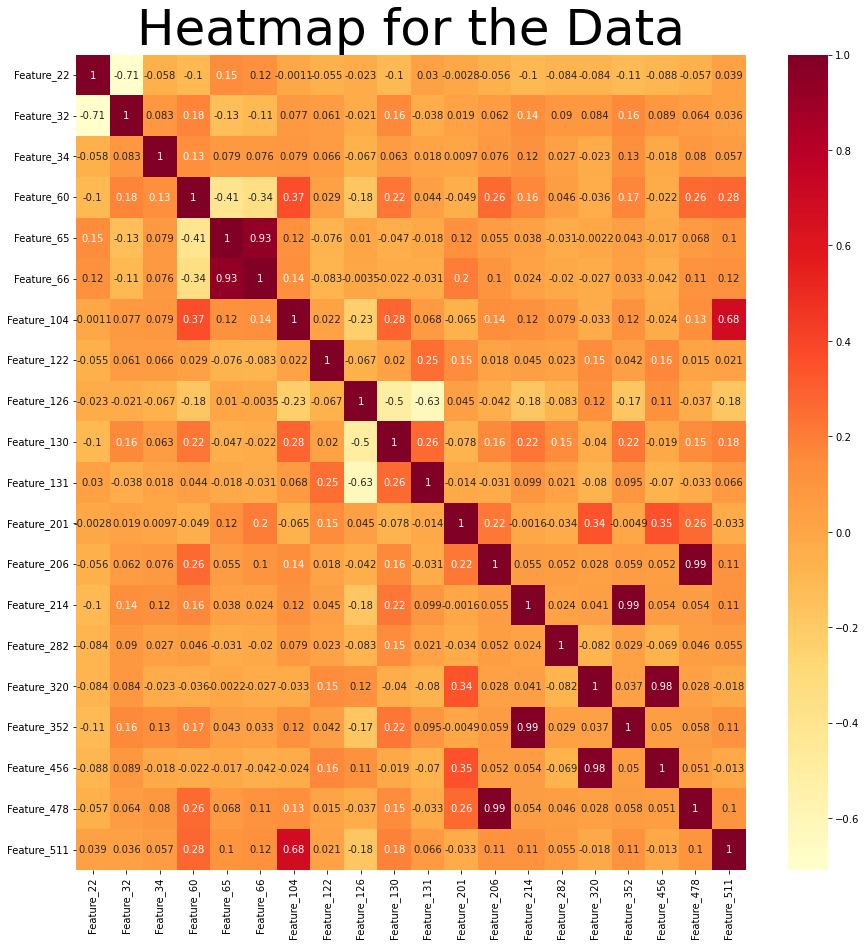

In [24]:
import seaborn as sns
# Heatmap for correlation
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(X_train_boruta.corr(),cmap="YlOrRd",annot=True)
plt.title('Heatmap for the Data', fontsize = 50)

# Applying steps to Test data

In [25]:
# Using selected features for training data
# From test set deleting columns that are removed in training set
X_test_boruta = X_test[np.array(X_train_boruta.columns)]

# replace with 3s in X_test
for col in X_test_boruta.columns:
    mean = X_test_boruta[col].mean()
    std_dev = X_test_boruta[col].std(axis=0)
    X_test_boruta[col] = X_test_boruta[col].map(lambda x: replace_outlier(x, mean, std_dev))
    
# Imputing the data with knn
knn.fit(X_test_boruta)
X_test_boruta=pd.DataFrame(knn.transform(X_test_boruta), columns=X_test_boruta.columns)
X_test_boruta.isna().sum().sum()

0

## Balancing the data using Rose

In [26]:
# Imbalance treatment
X_rose, y_rose = Sampling(X_train_boruta, y_train,'ROSE')

Counter({'Classification': 1})


# Scaling the data

In [30]:
X_train_std = scaling(X_rose)
y_train_std = scaling(y_rose)


Model Name: RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       n_jobs=-1, random_state=100)
Test Accuracy Score: 0.06687898089171974
F1 Score: 0.06687898089171974
Sensitivity: nan
Recall: 1.0
Precision: 0.06687898089171974


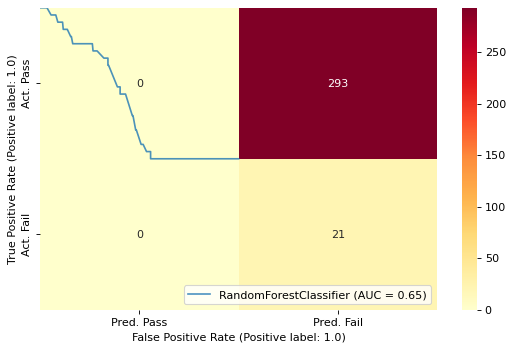

In [37]:
evaluate(RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100),X_train_std,X_test_boruta,y_train_std,y_test)

In [ ]:
# Random forest
params = {'criterion' : ["gini","entropy","log_loss"],
          'max_depth':[4,5,6,7,8,9,10],
         'max_features':["sqrt","log2","auto",None]}
          

grid_searcher = GridSearchCV(RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1), params,scoring='roc_auc', cv = 5, verbose=1)
grid_searcher.fit(X_rose, y_rose)
#plot_result_smoted_fe_tuned(grid_searcher, "dtc")

In [ ]:
grid_searcher.best_params_

In [ ]:
grid_searcher.best_estimator_


In [ ]:
evaluate2(grid_searcher.best_estimator_,X_rose,X_test_boruta,y_rose,y_test)


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split # for separating train and test data, scaling, model building, ...

# Evaluation using Startified K Fold cross validation
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(grid_searcher.best_estimator_, X_rose, y_rose, cv=cv, scoring = 'roc_auc')
print(scores.mean())
# fit
grid_searcher.best_estimator_.fit(X_rose, y_rose)    
# predict
y_pred_test = grid_searcher.best_estimator_.predict(X_test_boruta)
# View accuracy score
accuracyFinal = accuracy_score(y_test, y_pred_test)
print('Test Accuracy : ', accuracyFinal)
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt="d",cmap="YlOrRd",yticklabels = ['Act. Pass', 'Act. Fail'], xticklabels = ['Pred. Pass' , 'Pred. Fail'])

In [ ]:
# from sklearn.model_selection import KFold, StratifiedKFold, train_test_split # for separating train and test data, scaling, model building, ...

# # Evaluation using Startified K Fold cross validation
# cv = StratifiedKFold(n_splits=10)
# scores = cross_val_score(grid_searcher.best_estimator_, X_rose, y_rose, cv=cv, scoring = 'roc_auc')
# print(scores.mean())
# # fit
# grid_searcher.best_estimator_.fit(X_rose, y_rose)    
# # predict
# y_pred_test = grid_searcher.best_estimator_.predict(X_test_boruta)
# # View accuracy score
# accuracyFinal = accuracy_score(y_test, y_pred_test)
# print('Test Accuracy : ', accuracyFinal)
# sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt="d",cmap="YlOrRd",yticklabels = ['Act. Pass', 'Act. Fail'], xticklabels = ['Pred. Pass' , 'Pred. Fail'])